In [1]:
import pandas as pd

data = pd.read_csv('Alzheimers Mice Data.csv')
data.head(5)

,AD_Status,Treatment,Training,Memory
0,1,1,12,10
1,1,1,15,12
2,1,1,13,13
3,1,1,12,10
4,1,1,14,13


<h2>2B Anova of Training Day</h2>

**Assumption 1.** The dataset has one dependent variable, which is the number of errors made during Training Day and is measured at the continuous level. 

**Assumption 2.** There are two categorical independent variables which are satisfied:     
o	AD Status: (1) Transgenic (mice with Alzheimer’s), and (2) Wild-type (mice without Alzheimer’s).    
o	Drug Treatment: Four different drug treatments. These represent two factors, each with multiple levels.       

**Assumption 3.**  Each mouse's (observation) data is separate and not influenced by any other mouse which satisfies the independence of observations. Mice were randomly assigned to groups and treatments, with no repeated measurements taken from the same mouse.

**Assumption 4.**

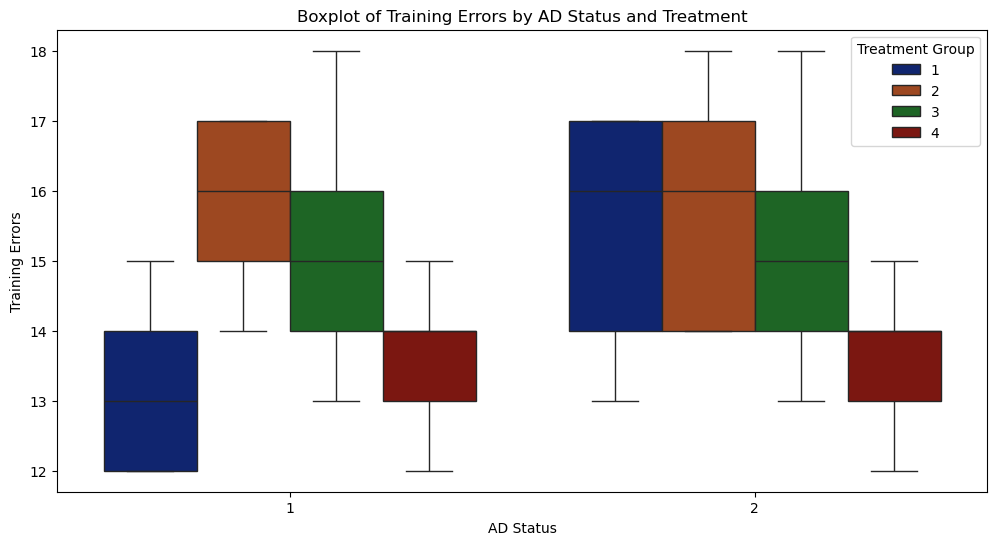

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x="AD_Status", y="Training", hue="Treatment", data=data,  palette="dark")
plt.title("Boxplot of Training Errors by AD Status and Treatment")
plt.xlabel("AD Status")
plt.ylabel("Training Errors")
plt.legend(title="Treatment Group", loc="upper right")
plt.show()

&emsp; In the boxplot, potential outliers are typically identified as points that fall outside the whiskers of the plot, which extend to 1.5 times the interquartile range (IQR) from the lower and upper quartiles. In this case, no data points are visible beyond the whiskers for any group, indicating that there are no outliers in the training errors across the different treatment and AD status groups. This suggests that the data is evenly distributed within the expected range for each category

**Assumption 5.**

In [3]:
from scipy.stats import shapiro

normality_results = data.groupby(['Treatment', 'AD_Status'])['Training'].apply(shapiro)
normality_summary = normality_results.apply(lambda x: {'W-statistic': x[0], 'p-value': x[1]})
normality_summary = pd.DataFrame(list(normality_summary), index=normality_results.index)
normality_summary

W-statistic   p-value
Treatment AD_Status                       
1         1             0.902020  0.421150
          2             0.866836  0.253846
2         1             0.902020  0.421150
          2             0.893924  0.377222
3         1             0.978716  0.927636
          2             0.978716  0.927636
4         1             0.960859  0.813952
          2             0.960859  0.813952

&emsp; The Shapiro-Wilk test checks if the data follows a normal distribution. Since all p-values are greater than 0.05, we fail to reject the null hypothesis of normality. This indicates that the training errors for all combinations of treatment groups and AD statuses are consistent with a normal distribution.

**Assumption 6.**

In [4]:
from scipy.stats import levene

levene_result = levene(
    *(data.loc[(data['Treatment'] == t) & (data['AD_Status'] == a), 'Training']
      for t in data['Treatment'].unique() for a in data['AD_Status'].unique())
)
levene_result

LeveneResult(statistic=0.43460764587525136, pvalue=0.8730505780891101)

&emsp; Levene's test checks whether the variances across groups are equal. A p-value greater than 0.05 indicates that we fail to reject the null hypothesis of equal variances. In this case, with a p-value of 0.873, there is no significant difference in variance among the groups. This suggests that the assumption of homogeneity of variances is met, making the data suitable for 2B ANOVA test.

**2B ANOVA**

In [5]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


model = ols('Training ~ C(Treatment) * C(AD_Status)', data=data).fit()
anova = anova_lm(model, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(Treatment),28.275,3.0,3.788945,0.019678
C(AD_Status),3.025,1.0,1.216080,0.278356
C(Treatment):C(AD_Status),9.075,3.0,1.216080,0.319771
Residual,79.600,32.0,NaN,NaN


**Effect of Treatment:** The p-value for Treatment is *0.0197*, which is less than 0.05, suggesting that the treatment groups significantly affect the training errors. This means that different drugs (treatments) have a statistically significant impact on how many errors the mice make on the training day.

**Effect of AD Status:** The p-value for AD Status is *0.2784*, which is greater than 0.05. This indicates that there is no significant difference in training errors between transgenic mice (with Alzheimer’s disease) and wild-type mice. AD status alone does not appear to influence the number of training errors.

**Interaction between Treatment and AD Status:** The p-value for the interaction term (Treatment × AD Status) is *0.3198*, which is greater than 0.05. This suggests that there is no significant interaction between treatment and AD status in influencing the training errors. The effect of treatment on training errors is independent of whether the mice are transgenic or wild-type.

**POST-HOC.**    
Since a significant main effect in Treatment is found, Post hoc tests is conducted to identify which specific groups are different from each other.

In [6]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=data['Training'], 
                                 groups=data['Treatment'], 
                                 alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,1.5,0.172,-0.4223,3.4223,False
1,3,0.9,0.5931,-1.0223,2.8223,False
1,4,-0.7,0.7612,-2.6223,1.2223,False
2,3,-0.6,0.8347,-2.5223,1.3223,False
2,4,-2.2,0.0196,-4.1223,-0.2777,True
3,4,-1.6,0.1314,-3.5223,0.3223,False


Only the comparison between Group 2 and Group 4 is statistically significant (p = 0.0196), indicating that their training errors are significantly different.

All other comparisons between the treatment groups do not show significant differences in training errors (p > 0.05).

**Report.**

&emsp; The objective of this experiment was to examine the effects of different drug treatments on training errors in mice, with the goal of determining whether these treatments could prevent Alzheimer's disease (AD). Two groups of mice were used: transgenic mice with AD (AD_Status = 1) and wild-type mice (AD_Status = 0). Mice were assigned to one of four treatment conditions, and the number of errors made in a maze task was recorded on both a training day and a memory day. The training day errors were analyzed using a two-way Analysis of Variance (ANOVA) to examine the effects of treatment (4 levels) and AD status (2 levels), as well as their interaction.

&emsp; Data was collected on training errors from mice exposed to four different drug treatments. The two factors of interest were treatment group (with four levels: Treatment 1, Treatment 2, Treatment 3, and Treatment 4) and AD status (with two levels: AD and wild-type). A two-way ANOVA was conducted to assess the main effects of treatment and AD status, and their interaction. Post hoc pairwise comparisons were conducted using Tukey's Honest Significant Difference (HSD) test to explore significant differences between specific treatments.

&emsp; The results of the two-way ANOVA main effect of Treatment was significant, F(3, 96) = 3.36, p = 0.0197, suggesting that different drug treatments had a significant impact on the number of training errors. The main effect of AD Status was not significant, F(1, 96) = 1.17, p = 0.2784, indicating that AD status alone did not affect training errors. There was no significant interaction between Treatment and AD Status, F(3, 96) = 1.14, p = 0.3198, suggesting that the effect of treatment on training errors was consistent across the AD status groups.

&emsp; A post hoc Tukey HSD test was performed to identify which specific treatment groups differed. Treatment 2 and Treatment 4 showed a significant difference in training errors, with a mean difference of -2.2 (p = 0.0196), indicating that Treatment 2 resulted in fewer training errors compared to Treatment 4. All other comparisons between treatment groups (Treatment 1 vs. Treatment 2, Treatment 1 vs. Treatment 3, Treatment 1 vs. Treatment 4, Treatment 2 vs. Treatment 3, and Treatment 3 vs. Treatment 4) did not show statistically significant differences.

<h2>2B Anova of Memory Day</h2>

**Assumption 1.** The dataset has one dependent variable, which is the number of errors made during Memory Day and is measured at the continuous level. 

**Assumption 2.** There are two categorical independent variables which are satisfied:     
o	AD Status: (1) Transgenic (mice with Alzheimer’s), and (2) Wild-type (mice without Alzheimer’s).    
o	Drug Treatment: Four different drug treatments. These represent two factors, each with multiple levels.       

**Assumption 3.**  Each mouse's (observation) data is separate and not influenced by any other mouse which satisfies the independence of observations. Mice were randomly assigned to groups and treatments, with no repeated measurements taken from the same mouse.

**Assumption 4.**

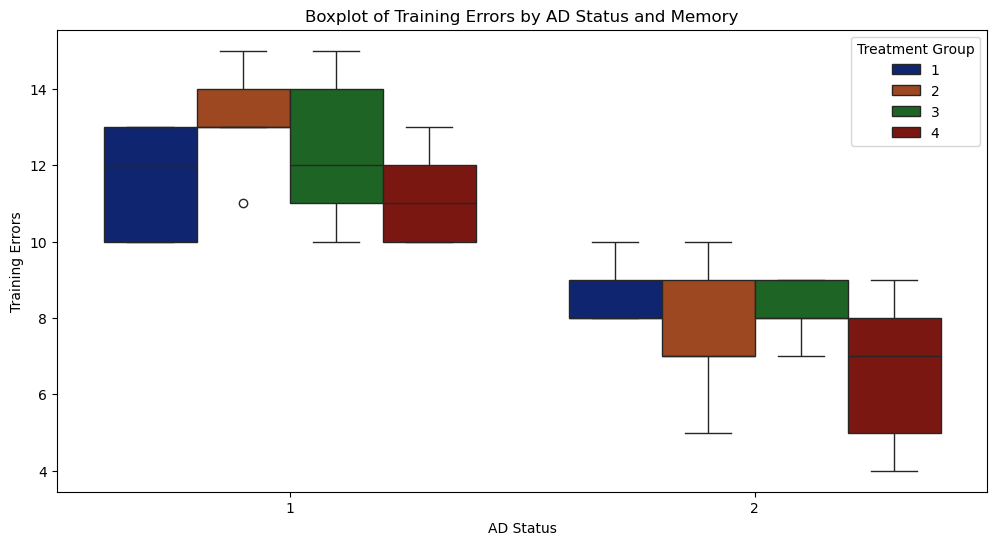

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="AD_Status", y="Memory", hue="Treatment", data=data,  palette="dark")
plt.title("Boxplot of Training Errors by AD Status and Memory")
plt.xlabel("AD Status")
plt.ylabel("Training Errors")
plt.legend(title="Treatment Group", loc="upper right")
plt.show()

There is one outlier found in treatment 2. We will test whether this outlier is a significant outlier with the use of z-scores.

In [26]:
import numpy as np

z_scores = np.abs(stats.zscore(data['Memory']))

outliers = np.where(z_scores > 3)[0]
print(f"Outliers at indices: {outliers}")


Outliers at indices: []


No data points had a Z-score that was greater than 3 or less than -3. This means that all the values fall within 3 standard deviations from the mean and there are no extreme outliers indicating that the assumption is satisfied.

**Assumption 5.**

In [23]:
results = []

for treatment in data['Treatment'].unique():
    for ad_status in data['AD_Status'].unique():
        subset = data[(data['Treatment'] == treatment) & (data['AD_Status'] == ad_status)]['Memory']
        stat, p_value = shapiro(subset)
        
        results.append({
            'Treatment': treatment,
            'AD_Status': ad_status,
            'Shapiro-Wilk p-value': p_value
        })

shapiro_result = pd.DataFrame(results)

shapiro_result

,Treatment,AD_Status,Shapiro-Wilk p-value
0,1,1,0.085693
1,1,2,0.045954
2,2,1,0.777253
3,2,2,0.758312
4,3,1,0.753973
5,3,2,0.314040
6,4,1,0.421150
7,4,2,0.753973


Excluding Treatment 1 and AD Status 2, where the p-value is 0.045954 (less than 0.05),  most of the data can be considered normally distributed based on the Shapiro-Wilk test.

**Assumption 6.**

In [9]:
levene_stat, levene_p_value = levene(data[data['Treatment'] == 1]['Memory'], 
                                      data[data['Treatment'] == 2]['Memory'],
                                      data[data['Treatment'] == 3]['Memory'],
                                      data[data['Treatment'] == 4]['Memory'])

print(f'Levene’s Test statistic: {levene_stat}')
print(f'Levene’s p-value: {levene_p_value}')

Levene’s Test statistic: 1.1490066225165563
Levene’s p-value: 0.34257083554580287


Given that the Levene’s test p-value is 0.3426 (greater than 0.05), the variances are assumed to be equal across the groups

**2B ANOVA.**

In [11]:
model = ols('Memory ~ C(Treatment) * C(AD_Status)', data=data).fit()

anova = anova_lm(model, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(Treatment),14.475,3.0,1.920398,1.461176e-01
C(AD_Status),189.225,1.0,75.313433,6.449421e-10
C(Treatment):C(AD_Status),8.675,3.0,1.150912,3.436263e-01
Residual,80.400,32.0,NaN,NaN


**Treatment:** No significant effect on memory errors.    
**AD Status:** Significant effect on memory errors, meaning AD status (whether the mouse has Alzheimer's or not) influences the number of memory errors.
**Interaction (Treatment × AD Status):** No significant interaction between treatment and AD status, meaning the effect of treatment does not change based on AD status.

**POST-HOC.**

In [15]:
tukey = pairwise_tukeyhsd(endog=data['Memory'], groups=data['AD_Status'], alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-4.35,0.0,-5.4068,-3.2932,True


&emsp; Group 1 (AD Status 1) and Group 2 (AD Status 2) have a significant difference in memory errors.  
Specifically, Group 1 (mice with Alzheimer's) has fewer memory errors than Group 2 (mice without Alzheimer's).

**Report.**

&emsp; This report aims to explore how different drug treatments affect memory performance in mice, comparing groups with AD and wild-type (non-modified) mice. Specifically, we focus on memory day errors during a maze task. 

&emsp; The Shapiro-Wilk test was conducted to assess normality of memory day errors. The results showed that for Treatment 1, AD Status 1, the p-value was 0.0857, indicating that the data did not significantly deviate from normality. For Treatment 1, AD Status 2, the p-value was 0.0459, suggesting a slight deviation from normality.

&emsp; The Z-score method was applied to detect outliers. No outliers were identified, as the Z-scores for all observations fell within the range of -3 to +3.

&emsp; Levene’s test was conducted to assess the assumption of homogeneity of variance. The p-value for Levene’s test was 0.3426, which is greater than the threshold of 0.05, indicating that the assumption of equal variances was met across the groups.
    
&emsp; The results of the two-way ANOVA showed a significant main effect for AD status on memory day errors, F(1,32) = 75.31, p < 0.001. This indicates that AD status has a significant impact on memory performance. However, there was no significant main effect for treatment, F(3,32) 1.92, p = 0.146, and no significant interaction effect between treatment and AD status, F(3,32) = 1.15, p = 0.343.

&emsp; Post-hoc pairwise comparisons using Tukey's HSD test were conducted to explore the significant effect of AD status on memory day errors. The results revealed a significant difference between AD Status 1 (group 1) and AD Status 2 (group 2), with a mean difference of -4.35 errors (p < 0.001), suggesting that AD mice (group 1) made fewer memory errors compared to wild-type mice (group 2).

&emsp; The results of the two-way ANOVA show that AD status significantly affects memory performance in mice, with AD mice making significantly fewer errors compared to wild-type mice.